# REALIZAMOS LAS IMPORTACIONES

In [6]:
from roboflow import Roboflow
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import os
from PIL import Image
import torchvision.transforms as T
from tqdm import tqdm

# DESCARGAMOS EL DATASET

In [ ]:
#download: https://github.com/ultralytics/assets/releases/download/v0.0.0/brain-tumor.zip

# DEFINIMOS EL BLOQUE DE CONVOLUCIÓN

In [7]:
def conv_block(in_channels, out_channels, kernel_size, stride=1, padding=0):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.1)
    )

# CREÁMOS NUESTRA RED YOLOv1

In [8]:
class YOLOv1_BN(nn.Module):
    def __init__(self, S=7, B=2, C=1):
        #super(YOLOv1_BN, self).__init__()
        super().__init__()
        self.S = S
        self.B = B
        self.C = C
        self.layers=[self.layer_1(),self.layer_2(),self.layer_3(),self.layer_4(),self.layer_5(),self.layer_6()]
        self.features = nn.Sequential(*self.layers)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024 * self.S * self.S, 4096),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.1),
            nn.Linear(4096, self.S * self.S * (self.C + self.B * 5))
        )

    def layer_1(self):
        return nn.Sequential( conv_block(3, 64, 7, stride=2, padding=3),nn.MaxPool2d(2, 2),)
    def layer_2(self):
       return nn.Sequential(conv_block(64, 192, 3, padding=1),
        nn.MaxPool2d(2, 2))
    def layer_3(self):
        return nn.Sequential(conv_block(192, 128, 1),
        conv_block(128, 256, 3, padding=1),
        conv_block(256, 256, 1),
        conv_block(256, 512, 3, padding=1),
        nn.MaxPool2d(2, 2))

    def layer_4(self):
        blocks = [
        nn.Sequential(
            conv_block(512, 256, 1),
            conv_block(256, 512, 3, padding=1)
        ) for _ in range(4)
        ]
        return nn.Sequential(*blocks,  conv_block(512, 512, 1),
            conv_block(512, 1024, 3, padding=1),
            nn.MaxPool2d(2, 2)
        )
    def layer_5(self):
        blocks = [
        nn.Sequential(
            conv_block(1024, 512, 1),
            conv_block(512, 1024, 3, padding=1)
        ) for _ in range(2)
        ]
        return nn.Sequential(*blocks,
            conv_block(1024, 1024, 3, padding=1),
            conv_block(1024, 1024, 3, stride=2, padding=1)
        )

    def layer_6(self):
        return nn.Sequential(
            conv_block(1024, 1024, 3, padding=1),
            conv_block(1024, 1024, 3, padding=1)
        )


    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x.view(-1, self.S, self.S, self.C + self.B * 5)


In [ ]:
model = YOLOv1_BN()
x = torch.randn(1, 3, 448, 448)
out = model(x)
print(out.shape)

# DATA LOADER

In [9]:
class TumorDataset(Dataset):
    def __init__(self, image_dir, label_dir, S=7, B=2, C=1):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = T.Compose([T.Resize((448, 448)), T.ToTensor()])
        self.S = S
        self.B = B
        self.C = C
        #al final image_filenames tendrá la lista de todas las imágenes ["tumor1.jpg","tumor2.jpg",...]
        self.image_filenames = [f for f in os.listdir(image_dir) if f.endswith(".jpg") or f.endswith(".png")]

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_filename = self.image_filenames[idx] # obtenemos la imagen acorde a su indice
        image_path = os.path.join(self.image_dir, image_filename) # obtenemos la ruta de la imagen
        # obtenemos la ruta del archivo de texto que contiene las etiquetas que debe tener el mismo nombre que la imagen
        label_path = os.path.join(self.label_dir, image_filename.replace(".jpg", ".txt").replace(".png", ".txt"))
        """
        Usa PIL.Image para abrir la imagen desde el disco
        .convert("RGB") asegura que la imagen tenga 3 canales (aunque venga en escala de grises o RGBA)
        """
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        """
            El modelo YOLOv1 devuelve una salida del mismo tamaño: (S, S, C + B*5), donde por cada celda predice:

            C scores de clase

            B bounding boxes, cada uno con:

            x, y: centro (relativo a la celda)

            w, h: tamaño (relativo a la imagen)

            conf: confianza de que hay un objeto

            Para que el loss pueda comparar la salida del modelo con la verdad del dataset, necesitas que tus etiquetas reales (ground truth) estén en ese mismo formato → y ahí entra label_tensor.
        """
        """
        Para una imagen con una etiqueta, el label_tensor contendrá valores diferentes de 0 solo en una celda. Por ejemplo, si un tumor está en la celda (3, 5):
        label_tensor[3, 5] = [clase, conf, x_cell, y_cell, w, h, 0, 0, 0, 0, 0]
            clase = 0 si solo tienes una
            conf = 1 porque hay un objeto
            x_cell, y_cell: posición dentro de la celda (0–1)
            w, h: tamaño del bbox
            El resto queda en cero (segunda caja no se usa)
        Si es que no existe el label tensor no se podría
        No podrías:

            Comparar correctamente la salida del modelo vs la verdad

            Usar loss_fn(preds, label_tensor)

            Entrenar correctamente YOLOv1, que espera una estructura específica
        """
        label_tensor = torch.zeros((self.S, self.S, self.C + self.B * 5))

        """
        Comprueba si el archivo .txt que contiene las etiquetas para esa imagen existe. Si no existe, simplemente deja el label_tensor lleno de ceros (es decir, sin objetos).
        """
        if os.path.exists(label_path):
            """
            Abre el archivo de etiquetas y recorre cada línea, que representa un objeto anotado.
            """
            with open(label_path) as f:
                for line in f.readlines():
                    """
                    ▶️ Extrae los 5 valores de cada línea:
                        class_id: ID de la clase (normalmente 0 si solo tienes una clase, como "tumor")
                        x, y: coordenadas del centro del objeto, normalizadas (entre 0 y 1)
                        w, h: ancho y alto del bounding box, normalizados
                    """
                    class_id, x, y, w, h = map(float, line.strip().split())
                    """
                     Esto ubica el objeto en la celda (j, i) de la cuadrícula S x S (por ejemplo, 7x7):
                        x * S: nos da la columna dentro de la cuadrícula
                        y * S: nos da la fila
                        Ejemplo:
                        Si x = 0.73 y S = 7 → int(0.73 * 7) = 5 → columna 5
                    """
                    i = int(x * self.S) # nos da la columna dentro de la cuadrícula
                    j = int(y * self.S) # nos da la fila dentro de la cuadrícula
                    """
                    Calcula coordenadas relativas a la celda
                    Esto da la posición del centro del objeto dentro de la celda (i, j) como un valor entre 0 y 1.
                    Ejemplo:
                    Si x * 7 = 5.12, y i = 5 → x_cell = 0.12
                    """
                    x_cell = x * self.S - i
                    y_cell = y * self.S - j
                    # El ancho y alto ya están normalizados por eso se usan directamente
                    w_cell = w # guardamos el ancho
                    h_cell = h # guardamos el alto

                    # Asignar al primer bbox
                    if label_tensor[j, i, self.C] == 0: # Verificamos si el label tenso está vacío
                        label_tensor[j, i, self.C] = 1  # confidencia
                        label_tensor[j, i, self.C + 1:self.C + 5] = torch.tensor([x_cell, y_cell, w_cell, h_cell])
                        label_tensor[j, i, 0] = class_id  # clase (una sola clase = 0)

        return image, label_tensor


# Calculo del IoU

In [10]:
def intersection_over_union(boxes_preds, boxes_labels):
    """
    boxes_preds: [x, y, w, h] formato centrado
    boxes_labels: [x, y, w, h] formato centrado
    """
    box1_x1 = boxes_preds[0] - boxes_preds[2] / 2
    box1_y1 = boxes_preds[1] - boxes_preds[3] / 2
    box1_x2 = boxes_preds[0] + boxes_preds[2] / 2
    box1_y2 = boxes_preds[1] + boxes_preds[3] / 2

    box2_x1 = boxes_labels[0] - boxes_labels[2] / 2
    box2_y1 = boxes_labels[1] - boxes_labels[3] / 2
    box2_x2 = boxes_labels[0] + boxes_labels[2] / 2
    box2_y2 = boxes_labels[1] + boxes_labels[3] / 2

    x1 = max(box1_x1, box2_x1)
    y1 = max(box1_y1, box2_y1)
    x2 = min(box1_x2, box2_x2)
    y2 = min(box1_y2, box2_y2)

    intersection = max(0, x2 - x1) * max(0, y2 - y1)

    box1_area = (box1_x2 - box1_x1) * (box1_y2 - box1_y1)
    box2_area = (box2_x2 - box2_x1) * (box2_y2 - box2_y1)

    union = box1_area + box2_area - intersection + 1e-6

    return intersection / union

# YOLOLOSS

In [11]:
class YOLOLoss(nn.Module):
    """
    S: cuadrícula S×S (ej. 7x7)
    B: cantidad de bounding boxes por celda
    C: cantidad de clases
    λ_coord: penalización más fuerte a errores en coordenadas
    λ_noobj: penalización más débil cuando no hay objeto
    """
    def __init__(self, S=7, B=2, C=1, lambda_coord=5, lambda_noobj=0.5):
        super(YOLOLoss, self).__init__()
        #Define la función de pérdida como Error Cuadrático Medio para todas las partes (coordenadas, clase, confianza)
        self.mse = nn.MSELoss(reduction='sum')
        self.S = S
        self.B = B
        self.C = C
        self.lambda_coord = lambda_coord
        self.lambda_noobj = lambda_noobj

    def forward(self, predictions, target):
        N = predictions.size(0)
        loss = 0
        #Itera cada imagen del batch, y cada celda (i, j) en la cuadrícula
        for n in range(N):
            for i in range(self.S):
                for j in range(self.S):
                    pred = predictions[n, i, j]
                    truth = target[n, i, j]

                    has_obj = truth[self.C]
                    if has_obj == 1:
                        # Comparar los dos bounding boxes
                        ious = []
                        for b in range(self.B):
                            start = self.C + b * 5 + 1
                            box_pred = pred[start:start+4]
                            box_true = truth[self.C+1:self.C+5]
                            iou = intersection_over_union(box_pred, box_true)
                            ious.append(iou)
                        best_box = torch.argmax(torch.tensor(ious))

                        # Coordenadas y confianza del mejor bbox
                        start = self.C + best_box * 5
                        pred_box = pred[start+1:start+5]
                        true_box = truth[self.C+1:self.C+5]

                        pred_conf = pred[start]
                        true_conf = truth[self.C]

                        # Pérdida de clase (opcional)
                        loss += self.mse(pred[0:self.C], truth[0:self.C])

                        # Pérdida de bbox (solo del mejor)
                        loss += self.lambda_coord * self.mse(pred_box, true_box)

                        # Pérdida de confianza del mejor bbox
                        loss += self.mse(pred_conf, true_conf)

                        # Penalizar confianza de los otros bboxes
                        for b in range(self.B):
                            if b != best_box:
                                conf = pred[self.C + b * 5]
                                loss += self.lambda_noobj * self.mse(conf, torch.tensor(0.))
                    else:
                        # No hay objeto → penalizar ambos bboxes
                        for b in range(self.B):
                            conf = pred[self.C + b * 5]
                            loss += self.lambda_noobj * self.mse(conf, torch.tensor(0.))

        return loss / N


# ENTRENAMIENTO

In [ ]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import os

def train_yolov1(
    model,
    dataset,
    loss_fn,
    device="cuda" if torch.cuda.is_available() else "cpu",
    epochs=50,
    batch_size=16,
    lr=1e-4,
    checkpoint_path="yolov1_final.pth",
    save_best=True
):
    # DataLoader
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    # Preparación del modelo
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)

    best_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        loop = tqdm(dataloader, leave=False)
        for imgs, labels in loop:
            imgs, labels = imgs.to(device), labels.to(device)

            preds = model(imgs)
            loss = loss_fn(preds, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
            loop.set_postfix(loss=loss.item(), avg_loss=epoch_loss / (loop.n + 1))

        avg_loss = epoch_loss / len(dataloader)
        scheduler.step()

        print(f"📉 Epoch {epoch+1}/{epochs} — Loss: {avg_loss:.4f}")

        # Guardar mejor modelo
        if save_best and avg_loss < best_loss:
            best_loss = avg_loss
            torch.save(model.state_dict(), "best_model.pth")
            print(f"✅ Nuevo mejor modelo guardado (Loss: {best_loss:.4f})")

        # Checkpoints periódicos
        if (epoch + 1) % 5 == 0:
            ckpt_name = f"checkpoint_epoch{epoch+1}.pth"
            torch.save(model.state_dict(), ckpt_name)
            print(f"💾 Checkpoint guardado: {ckpt_name}")

    # Guardar modelo final
    torch.save(model.state_dict(), checkpoint_path)
    print(f"🎯 Modelo final guardado en: {checkpoint_path}")



In [12]:
model = YOLOv1_BN(S=7, B=2, C=1)
loss_fn = YOLOLoss(S=7, B=2, C=1)

train_dataset = TumorDataset(
    image_dir = r"D:\programacion\proyectos\utec\IA\modulo_2_redes_convolucionales_y_generativas\yolo\brain-tumor\train\images",
    label_dir = r"D:\programacion\proyectos\utec\IA\modulo_2_redes_convolucionales_y_generativas\yolo\brain-tumor\train\labels",
    S=7, B=2, C=1,
)


train_yolov1(
    model=model,
    dataset=train_dataset,
    loss_fn=loss_fn,
    epochs=50,
    batch_size=16,
    lr=1e-4
)

NameError: name 'train_yolov1' is not defined

# Evaluación del modelo

In [13]:
model = YOLOv1_BN(S=7, B=2, C=1)
model.load_state_dict(torch.load("yolov1_final.pth", map_location=torch.device("cpu")))
model.eval()

YOLOv1_BN(
  (features): Sequential(
    (0): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1)
      )
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Sequential(
        (0): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1)
      )
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Sequential(
        (0): Conv2d(192, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

# Creamos una función de predicción

In [14]:
import torchvision.transforms as T
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

def show_prediction_on_image(model, image_path, S=7, B=2, C=1, conf_threshold=0.4):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    model.eval()

    transform = T.Compose([T.Resize((448, 448)), T.ToTensor()])

    image = Image.open(image_path).convert("RGB")
    original_w, original_h = image.size
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor).squeeze(0).cpu()

    best_conf = 0
    best_box = None
    for i in range(S):
        for j in range(S):
            cell = output[i, j]
            for b in range(B):
                conf = cell[C + b * 5]
                if conf > best_conf and conf > conf_threshold:
                    x_rel, y_rel, w_rel, h_rel = cell[C + b * 5 + 1:C + b * 5 + 5]
                    best_conf = conf
                    best_box = (j, i, x_rel, y_rel, w_rel, h_rel)

    draw = ImageDraw.Draw(image)
    if best_box:
        j, i, x_cell, y_cell, w, h = best_box
        x_center = (j + x_cell) / S * original_w
        y_center = (i + y_cell) / S * original_h
        width = w * original_w
        height = h * original_h

        x1 = x_center - width / 2
        y1 = y_center - height / 2
        x2 = x_center + width / 2
        y2 = y_center + height / 2

        draw.rectangle([x1, y1, x2, y2], outline="red", width=3)
        draw.text((x1, y1 - 10), f"conf: {best_conf:.2f}", fill="red")
    else:
        print("⚠️ No se detectó ningún objeto con suficiente confianza.")

    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis("off")
    plt.title("Predicción YOLOv1 - Tumor cerebral")
    plt.show()


# Implementamos

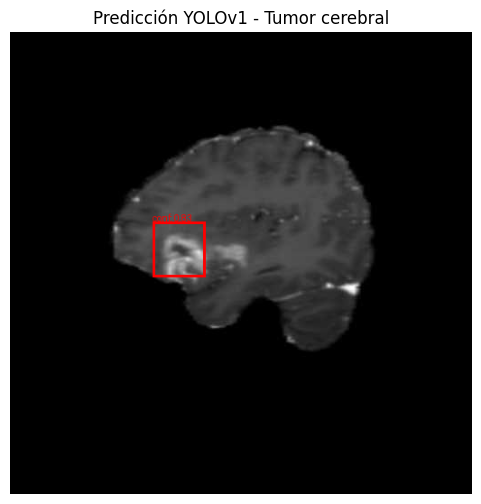

In [15]:
show_prediction_on_image(model, r"D:\programacion\proyectos\utec\IA\modulo_2_redes_convolucionales_y_generativas\yolo\brain-tumor\valid\images\val_1 (1).jpg")
